In [1]:
import open3d as o3d # для работы с 3D геометрией (меши (совокупность вершин, рёбер и полигонов), облака точек)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import files

uploaded = files.upload()

Saving chair_0891.off to chair_0891 (1).off


In [4]:
# Загружаем mesh из .off файла
mesh = o3d.io.read_triangle_mesh("chair_0891 (1).off")

In [5]:
# Сэмплируем облако точек
pcd = mesh.sample_points_poisson_disk(number_of_points=2048)

In [6]:
# Преобразуем в numpy
points = np.asarray(pcd.points)

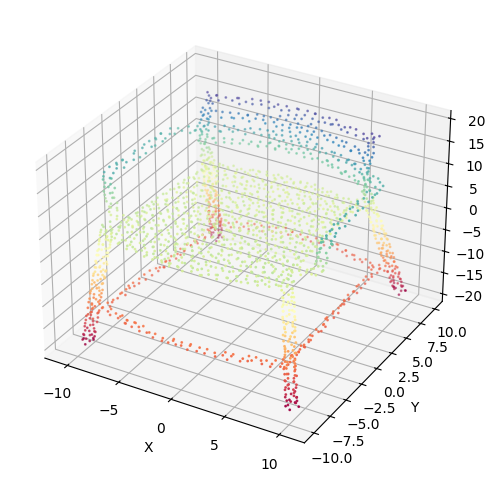

In [7]:
# Визуализируем через matplotlib
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:,2], s=1, c=points[:,2], cmap="Spectral")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [8]:
import open3d.ml.torch as ml3d

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class Tnet(nn.Module): # обучаемая линейная трансформация k*k

   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)


   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))

      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix # обучаемая матрица трансформации

class Transform(nn.Module): # извлечение признаков
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3) # для выравнивания входных координат
        self.feature_transform = Tnet(k=64) # для выравнивания пространства признаков
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb) # матрица признаков
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb) # дескриптор объекта
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module): # классификатор
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)


        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64 # натуральные логарифмы вероятностей

In [22]:
# словарь классов ModuleNet10
CLASSES = {
    0: 'bathtub',
    1: 'bed',
    2: 'chair',
    3: 'desk',
    4: 'dresser',
    5: 'monitor',
    6: 'night_stand',
    7: 'sofa',
    8: 'table',
    9: 'toilet'
}

In [20]:
def preprocess_off(file_path, num_points=1024):
    """
    Загружает 3D-модель из OFF-файла,
    дискретизирует поверхность в облако точек,
    нормализует и возвращает тензор PyTorch.
    """
    mesh = o3d.io.read_triangle_mesh(file_path)
    if mesh.is_empty():
        raise ValueError("Файл пуст или не найден!")

    pcd = mesh.sample_points_uniformly(number_of_points=num_points)

    points = np.asarray(pcd.points)
    points = points - np.mean(points, axis=0)
    max_dist = np.max(np.sqrt(np.sum(points ** 2, axis=1)))
    points = points / max_dist

    points = points.transpose(1, 0).astype(np.float32)
    tensor = torch.from_numpy(points).unsqueeze(0)
    return tensor # возвращаем тензор PyTorch

In [23]:
def predict(model_path, image_path):
  # функция предикта
    model = PointNet()

    try:
        model.load_state_dict(torch.load(model_path, map_location='cpu'))
        model.eval()
    except Exception as e:
        print(f"Предупреждение: Веса не загружены! ({e})")
        model.eval()

    input_tensor = preprocess_off(image_path)

    with torch.no_grad():
        log_probs, _, _ = model(input_tensor)

        probs = torch.exp(log_probs)

        pred_idx = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_idx].item()

    return CLASSES[pred_idx], confidence

In [14]:
from google.colab import files

uploaded = files.upload()

Saving model.pth to model (1).pth


In [24]:
file = 'chair_0891.off'

class_name, conf = predict('model.pth', file)

print(f"\nРезультат: {class_name.upper()}")
print(f"Уверенность: {conf:.2%}")


Результат: CHAIR
Уверенность: 100.00%


In [18]:
from google.colab import files

uploaded = files.upload()

Saving monitor_0476.off to monitor_0476.off


In [17]:
file = 'bed_0529.off'
class_name, conf = predict('model.pth', file)

print(f"\nРезультат: {class_name.upper()}")
print(f"Уверенность: {conf:.2%}")


Результат: BED
Уверенность: 95.23%


In [19]:
file = 'monitor_0476.off'
class_name, conf = predict('model.pth', file)

print(f"\nРезультат: {class_name.upper()}")
print(f"Уверенность: {conf:.2%}")


Результат: MONITOR
Уверенность: 92.91%
